# Clustering longitudinal time series with Conditional Neural Process 01

## Setup pytorch and numpy

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.distributions import Normal

In [2]:
torch.__version__

'0.4.1.post2'

## Define this conditional neural process modules

There are two submodules "encoder" and "decoder" defined in the following cell.
The conditional neural process (CNP) module uses the encoder module that takes an input "context" tensor and encond the "context" into latent variables.  Combined with the latent variable and the a "target_x" value, the decode can predict the mean (mu) and deviation (sigma) of the targeted y value.  The parameters from the full connected layers are optimized by maximmu the log-likely of the observed y value according to the predicted mean and deviation.

In [3]:
class CNP_encoder(nn.Module):
    def __init__(self, layers=(2, 128, 128, 128 ,128)):
        """
        The keyword argument `layers` allows to speficy the number of nodes and 
        the number of layers for the full connected layers. The first 
        dimension should be (input_dim_size + 1)
        """
        super(CNP_encoder, self).__init__()
        
        modules = []
        for i in range(0, len(layers)-2):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.ReLU())
        
        modules.append(nn.Linear(layers[-2], layers[-1]))
        self.layers = nn.Sequential(*modules)
        
    def forward(self, context, context_mask):
        """
        context: tensor for the context of shape (batch_size, max_seq, input_dim_size+1)
        context_mask: tensor for masking unequal sequences of shape (batch_size, max_seq)
        """        

        h = self.layers(context)
        n = torch.stack( [torch.sum(context_mask, 1)] * h.shape[-1], dim =1)
        batch_size, seq_size = context_mask.shape
        x_mask= torch.stack([context_mask]* h.shape[-1] ,dim=2)
        h = torch.sum(h,1) / n.float()
        return h
    
class CNP_decoder(nn.Module):
    def __init__(self, layers=(128, 128, 128, 128)):
        """
        The keyword argument `layers` allows to speficy the number of nodes and 
        the number of layers for the full connected layers.
        """
        super(CNP_decoder, self).__init__()
        
        modules = [nn.Linear(layers[0]+1, layers[1])]
        modules.append(nn.ReLU())
        
        for i in range(1, len(layers)-1):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.ReLU())
        
        modules.append(nn.Linear(layers[-1], 2))
        self.layers = nn.Sequential(*modules)
        
    def forward(self, latent_target):
        """
        latent_target: 
        tensor for the latent + target input of shape (batch_size, latent_size+input_dim_size)
        """        
        h = self.layers(latent_target)
        mu = h[:,:,0]
        log_sigma = h[:,:,1]
        sigma = 0.1 + 0.9 * nn.functional.softplus(log_sigma)
        return mu, sigma

    
class CNP(nn.Module):
    def __init__(self, encoder_layers=(2, 128, 128, 128 ,128),
                       decoder_layers=(128, 128, 128, 128)):
        super(CNP, self).__init__()
        self.encoder = CNP_encoder(layers=encoder_layers)
        self.decoder = CNP_decoder(layers=decoder_layers)
        
    def init_weights(self):
        def init_weights_(m):
            if type(m) == nn.Linear:
                nn.init.xavier_uniform_(m.weight)
        self.apply(init_weights_)
    
    def forward(self, context, context_mask, target_x):
        h = self.encoder.forward(context, context_mask)
        h=torch.stack( [h]*target_x.shape[1], dim=1)
        h=torch.cat( (h, target_x), dim=2) 
        self.mu, self.sigma = self.decoder.forward(h)
        return self.mu, self.sigma
    

    def get_latent(self, context, context_mask):
        h = self.encoder.forward(context, context_mask)
        return h
    
    def loss(self, target_y, target_mask):
        s = target_y.shape
        target_y = target_y.reshape( (s[0], s[1]) )   
        mvn = Normal(self.mu, self.sigma)
        loss = -torch.sum(mvn.log_prob(target_y) * target_mask.float())
        return loss
    

Define an useful utility function helping us to prepare data to feed into the CNP network

In [4]:
def get_context_target_tensor(data, repeat = 1, sampling_rate = 0.5, min_size = 4, cuda=True): 
    """
        with input data = list of (x_i, y_i), 
            x_i: numpy array of float
            y_i: numpy array of float
        
        output torch tensor for context from x, y with `simpling_rate`
        
        the whole arry will be repeated sample with `repeat` times
        
        the output are list of tensors: context_t, context_mask_t, target_x_t, target_y_t, target_mask_t
            
            context_t, context_mask_t: context tensors 
                
                context_t.shape = (batch_dim_size, max_seq_len, 2)
                context_mask_t.shape = (batch_dim_size, max_seq_len)
                batch_dim_size = len(x) * repeat
                max_seq_len = max seq length in the context array
                
            target_x_t, target_y_t, target_mask_t: target tensors
             
                target_x_t.shape = (batch_dim_size, max_seq_len, 1)
                target_y_t.shape = (batch_dim_size, max_seq_len, 1)
                target_mask_t.shape = (batch_dim_size, max_seq_len)
                batch_dim_size = len(x) * repeat
                max_seq_len = max seq length in the target array
    """
    
    context = []
    context_mask = []
    target_x = []
    target_y = []
    target_mask = []
    
    for _ in range(repeat):
        for x, y in data:
            assert len(x) == len(y)
            if len(x) < min_size:
                continue

            assert sampling_rate <= 1
            if sampling_rate < 1:
                sample_size = math.ceil(len(x) * sampling_rate)      
                idx = random.sample(range(len(x)), sample_size)
                context_x = x[idx]
                context_y = y[idx]
            else:
                context_x = x
                context_y = y

            context.append(torch.tensor(np.array(list(zip(context_x, context_y))), dtype=torch.float))
            context_mask.append(torch.ones(len(context_x), dtype=torch.long))

            target_x.append(torch.tensor(np.array([x]).T, dtype=torch.float))
            target_y.append(torch.tensor(np.array([y]).T, dtype=torch.float))

            target_mask.append(torch.ones(len(x), dtype=torch.long))
    
    context_t = torch.nn.utils.rnn.pad_sequence(context, batch_first=True, padding_value=0)
    context_mask_t = torch.nn.utils.rnn.pad_sequence(context_mask, batch_first=True, padding_value=0)
    target_x_t = torch.nn.utils.rnn.pad_sequence(target_x, batch_first=True, padding_value=0)
    target_y_t = torch.nn.utils.rnn.pad_sequence(target_y, batch_first=True, padding_value=0)
    target_mask_t = torch.nn.utils.rnn.pad_sequence(target_mask, batch_first=True, padding_value=0)
    
    if cuda:
        context_t = context_t.cuda()
        context_mask_t = context_mask_t.cuda()
        target_x_t = target_x_t.cuda()
        target_y_t = target_y_t.cuda()
        target_mask_t = target_mask_t.cuda()
        
    return context_t, context_mask_t, target_x_t, target_y_t, target_mask_t 

loading matplotlib for plotting

In [5]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [6]:

cnp = CNP().cuda()

## One can try a small CNP model 
# cnp = CNP(encoder_layers=(2, 16, 16),
#          decoder_layers=(16, 16, 16)).cuda()

cnp.init_weights()

# we add `weight_decay=5` to avoid overfitting to each individual curve 
optimizer = torch.optim.Adam(cnp.parameters(), lr=0.001, weight_decay=5)

 We generate 1000 curvers from two different function form with noise to train a CNP

In [7]:
data_train = []
for i in range(1000):
    x = np.linspace(0, 6, 10)
    if random.uniform(0, 1) < 0.5:
        y = 1 + np.sin(x/2)  + np.array( [random.normalvariate(0, 0.25) for x in range(10)] )
    else:
        y = 1 + np.sin(x/3)  + np.array( [random.normalvariate(0, 0.25) for x in range(10)] )
    data_train.append( (x, y) )

Training the CNP module

In [8]:
from tqdm import tqdm

In [9]:
(context_t, context_mask_t, 
 target_x_t, target_y_t, target_mask_t) = get_context_target_tensor(data_train, repeat=3)

loss_list = []
batch_size = 100
for i in tqdm(range(100)):
    for j in range(int(len(context_t)/batch_size)):
        s = random.randint(0, len(context_t)-batch_size)
        cnp(context_t[s:s+batch_size], 
            context_mask_t[s:s+batch_size], 
            target_x_t[s:s+batch_size])
        loss = cnp.loss(target_y_t[s:s+batch_size], 
                        target_mask_t[s:s+batch_size])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if i % 5 == 0:
        cnp(context_t, context_mask_t, target_x_t)
        loss = cnp.loss(target_y_t, target_mask_t)
        # print("epoch", i, loss.item())
        loss_list.append( (i, loss.item()) )

100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


visualizing the training loss

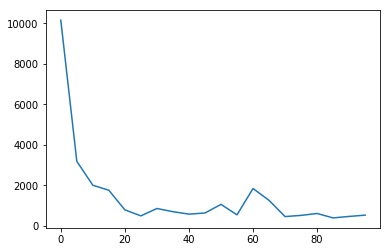

In [10]:
xx, yy = list(zip(*loss_list))
plt.plot(xx, yy)

define a function so we can visualize the prediction from a given context tensor

In [11]:
def test_model(model=None):
    n_points = 20
    x = np.linspace(0, 6, n_points)
    
    y1_ = 1 + np.sin(x/2) 
    y2_ = 1 + np.sin(x/3)
    
    y1 = y1_  + np.array( [random.normalvariate(0, 0.25) for x in range(n_points)] )
    y2 = y2_  + np.array( [random.normalvariate(0, 0.25) for x in range(n_points)] )

    
    if model==1:
        group = "1"
        y = y1
        y_ = y1_
    else:
        group = "2"
        y = y2
        y_ = y2_
        
    data = [ (x, y)]
    
    (context_t, 
     context_mask_t, 
     target_x_t, 
     target_y_t, 
     target_mask_t) = get_context_target_tensor(data, sampling_rate=1)
    
    mu, sigma = cnp(context_t, context_mask_t, target_x_t)

    context = context_t.detach().cpu().numpy()
    context_x, context_y = list(zip(*context[0]))
    
    fig, ax = plt.subplots(1, 1, sharex=True)
    
    plt.plot(context_x, context_y, "d", markersize=12, label="context")
    plt.plot(x, mu.detach().cpu().numpy().T, 'o--', label="predict")
    plt.plot(x, y1_, '.-r', label="1")
    plt.plot(x, y2_, '.-k', label="2")
    plt.legend()
    mu_ = mu.detach().cpu().numpy().flatten()
    sigma_ = sigma.detach().cpu().numpy().flatten()
    plt.fill_between(x, mu_ - sigma_, mu_ + sigma_, facecolor='c', alpha=0.5)
    plt.text(3, 0.8, "context generated with model {}".format(group))
    plt.xlim(-0.5, 9.5)
    plt.ylim(0.5, 2.5)   

Test the model by randomly drewing some context point from either model 1 or model 2. We can compare the predict curves to the model curve.

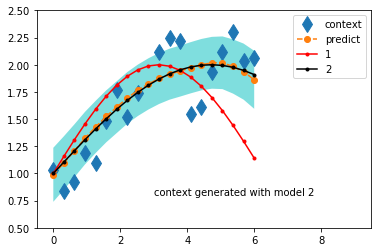

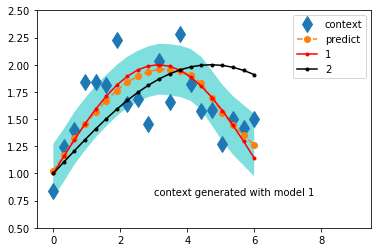

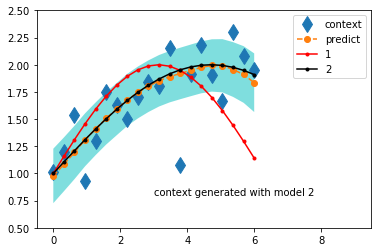

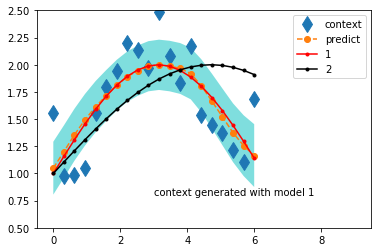

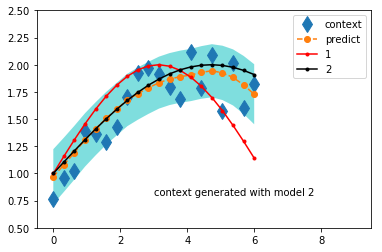

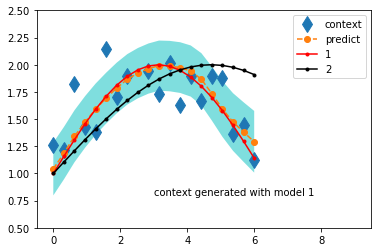

In [12]:
for i in range(6):
    test_model(model=i%2)

### Generate 500 random samples and visualized the latent space variable 

In [13]:
group = []
data = []
for i in range(500):
    n_points = 20
    x = np.linspace(0, 6, n_points)
    y1 = 1 + np.sin(x/2)  + np.array( [random.normalvariate(0, 0.25) for x in range(n_points)] )
    y2 = 1 + np.sin(x/3)  + np.array( [random.normalvariate(0, 0.25) for x in range(n_points)] )
    if random.uniform(0, 1) < 0.5:
        group.append(0)
        y = y1
    else:
        group.append(1)
        y = y2
    data.append((x, y))
    
(context_t, 
 context_mask_t, 
 target_x_t, 
 target_y_t, 
 target_mask_t) = get_context_target_tensor(data, sampling_rate=1)


## Let's visualize the latent space vector by t-SNE embedding

In [14]:
latent = []
for i in range(0, 500, 100):
    l_ = cnp.get_latent(context_t[i:i+100], context_mask_t[i:i+100])
    latent.extend(l_.detach().cpu().numpy())
latent=np.stack(latent)
group = np.array(group)

In [15]:
from sklearn.manifold import TSNE

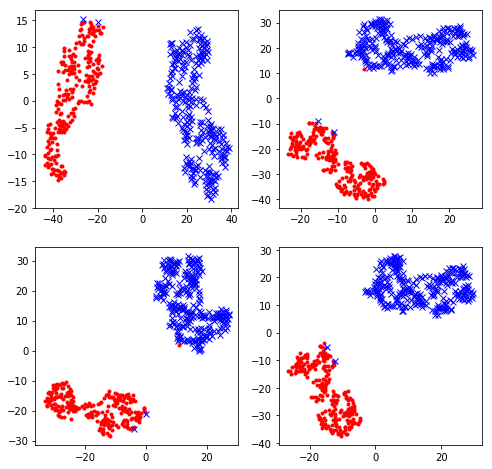

In [16]:
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    X_embedded = TSNE(n_components=2).fit_transform(latent)
    idx = group ==0
    plt.plot(X_embedded[idx,0], X_embedded[idx,1], '.r')
    idx = group ==1
    plt.plot(X_embedded[idx,0], X_embedded[idx,1], 'xb')

-- Jason Chin, Oct. 7 2018